<h1>Movie Data Analysis</h1>

<h3>Author: Mike Roth</h3>

<img src='img/movieproduction.png' />

<h1>Project Overview</h1>

This project analyzes data from [imdb.com](https://imdb.com) to make recommendations for what movies to produce for a new movie studio. Analysis of the dataset shows that certain movies and genres are more profitable than others and a new studio can use this analysis to plan and produce movies in order to make a profit.
    

<h2>Business Problem</h2>

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. We are charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

<img src='img/MicrosoftLogo.png' width='50%'/>

<h2>Data Understanding</h2>

[Imdb.com](https://imdb.com) has the largest resource of movie data publicly available on the internet. IMDB provides some easily accessible and formatted datasets that contain basic information for analyzing movies. While this dataset is robust, it does not contain the budget and box office information that we need to determine profitability. We decided to create our own dataset of movie information by scraping the database with python. We decided not to choose the whole dataset of movie data available from IMDB, but instead a subset of the data relevant to the business problem. We selected films that were made between 2010 and 2021, that were produced in the US, and were longer than one hour. Further, we will clean the data to include only titles that contain budget and box office information, as not every title on IMDB contains these features.

<h2>Let's begin!</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import pyarrow.feather as feather
from adjustText import adjust_text

%matplotlib inline

<h2>Load the scraped data from IMDB</h2>

<p>In a previous notebook (imdb_scraper.ipynb), we scraped title data from imdb.com to get budget and box office info. Now, it's time to reload that data.</p>

<p>We will use feather to import the file. We previously used a feather file to save the data because we created a dataframe with lists and dictionaries and the feather file will preserve those datatypes when we load it.</p>

In [2]:
#load the feather file from the data we scraped from imdb.com

imdb_df = feather.read_feather('imdb_scrape_full.feather')

In [3]:
#display the dataframe to make sure everything is loaded

imdb_df.head()

,id,url,title,year,genre,certificate,runtime,imdb_rating,metascore,principals,director,creator,budget,domestic_box_office,worldwide_box_office,origin,genre_1,genre_2,genre_3
0,tt1477834,/title/tt1477834/,Aquaman,2018,"[Action, Adventure, Fantasy]",PG-13,143,6.8,55.0,"[{'id': 'nm0597388', 'name': 'Jason Momoa'}, {...","[{'id': 'nm1490123', 'name': 'James Wan'}]","[{'id': 'co0002663'}, {'id': 'co0283444'}, {'i...",160000000.0,335104314.0,1.148528e+09,"[United States, Australia]",Action,Adventure,Fantasy
1,tt1879016,/title/tt1879016/,Operation Mincemeat,2021,"[Drama, War]",PG-13,128,6.7,NaN,"[{'id': 'nm0000147', 'name': 'Colin Firth'}, {...","[{'id': 'nm0006960', 'name': 'John Madden'}]","[{'id': 'co0230132'}, {'id': 'co0243890'}, {'i...",NaN,NaN,1.228859e+07,"[United Kingdom, United States]",Drama,War,None
2,tt4513678,/title/tt4513678/,Ghostbusters: Afterlife,2021,"[Adventure, Comedy, Fantasy]",PG-13,124,7.1,45.0,"[{'id': 'nm4689420', 'name': 'Carrie Coon'}, {...","[{'id': 'nm0718646', 'name': 'Jason Reitman'}]","[{'id': 'co0050868'}, {'id': 'co0309252'}, {'i...",75000000.0,129360575.0,1.973606e+08,"[United States, Canada]",Adventure,Comedy,Fantasy
3,t10954652,/title/tt10954652/,Old,2021,"[Drama, Horror, Mystery]",PG-13,108,5.8,55.0,"[{'id': 'nm0305558', 'name': 'Gael García Bern...","[{'id': 'nm0796117', 'name': 'M. Night Shyamal...","[{'id': 'co0005073'}, {'id': 'co0054054'}, {'i...",NaN,48276510.0,9.014651e+07,"[United States, Japan]",Drama,Horror,Mystery
4,t10872600,/title/tt10872600/,Spider-Man: No Way Home,2021,"[Action, Adventure, Fantasy]",PG-13,148,8.3,NaN,"[{'id': 'nm4043618', 'name': 'Tom Holland'}, {...","[{'id': 'nm1218281', 'name': 'Jon Watts'}]","[{'id': 'co0050868'}, {'id': 'co0532247'}, {'i...",200000000.0,804747988.0,1.892748e+09,[United States],Action,Adventure,Fantasy


In [4]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5000 non-null   object 
 1   url                   5000 non-null   object 
 2   title                 5000 non-null   object 
 3   year                  5000 non-null   int64  
 4   genre                 5000 non-null   object 
 5   certificate           4508 non-null   object 
 6   runtime               5000 non-null   int64  
 7   imdb_rating           4999 non-null   float64
 8   metascore             1560 non-null   float64
 9   principals            4999 non-null   object 
 10  director              5000 non-null   object 
 11  creator               4995 non-null   object 
 12  budget                2429 non-null   float64
 13  domestic_box_office   2646 non-null   float64
 14  worldwide_box_office  3384 non-null   float64
 15  origin               

Looking at the info on the dataframe, we are missing a lot of rows from the budget and box office columns. We will want to eventually drop the rows that are missing BOTH budget and worldwide_box_office data so that we can metrics that will use those both. These will be the most important columns in our dataset.

We are also missing rows in the 2nd and 3rd genre columns, but we expect that since not every title has multiple genres.

<h2>Clean dataframe and add features</h2>

<p>First let's drop rows that have no values for budget and worldwide_box_office</p>

In [5]:
#create a copy of the dataframe and drop rows that have nan's in both the budget and worldwide_box_office columns
imdb_budgets = imdb_df.loc[:]
imdb_budgets.dropna(subset=['budget','worldwide_box_office'], inplace=True)

<p>Now we will add features for the data we scraped.</p>

<p>We will want to compare new metrics from the budget and box office features, so we will create new columns.</p>

<p>The first two columns we want to create:</p>
<ul>
    <li>ROI - return of investment = worldwide box office / budget * 100</li>
    <li>Profit = worldwide box office - budget</li>

In [6]:
#create new features
imdb_budgets['roi'] = (imdb_df.worldwide_box_office / imdb_df.budget) * 100
imdb_budgets['profit'] = imdb_df.worldwide_box_office - imdb_df.budget

In [7]:
imdb_budgets.sort_values('roi', ascending=False).head()

,id,url,title,year,genre,certificate,runtime,imdb_rating,metascore,principals,...,creator,budget,domestic_box_office,worldwide_box_office,origin,genre_1,genre_2,genre_3,roi,profit
3759,tt6032704,/title/tt6032704/,Apparition,2019,[Horror],None,83,3.0,NaN,"[{'id': 'nm0002546', 'name': 'Mena Suvari'}, {...",...,"[{'id': 'co0652466'}, {'id': 'nm0020811'}, {'i...",1.0,NaN,175038.0,[United States],Horror,None,None,1.750380e+07,175037.0
3196,tt2309260,/title/tt2309260/,The Gallows,2015,"[Horror, Mystery, Thriller]",R,81,4.2,NaN,"[{'id': 'nm3790547', 'name': 'Reese Mishler'},...",...,"[{'id': 'co0046718'}, {'id': 'co0098315'}, {'i...",100000.0,22764410.0,42964410.0,[United States],Horror,Mystery,Thriller,4.296441e+04,42864410.0
870,tt8781414,/title/tt8781414/,Freaks,2018,"[Drama, Mystery, Sci-Fi]",R,105,6.7,NaN,"[{'id': 'nm0386472', 'name': 'Emile Hirsch'}, ...",...,"[{'id': 'co0708742'}, {'id': 'co0506709'}, {'i...",2000.0,276591.0,368410.0,"[United States, Canada]",Drama,Mystery,Sci-Fi,1.842050e+04,366410.0
3004,tt1560985,/title/tt1560985/,The Devil Inside,2012,[Horror],R,83,4.2,NaN,"[{'id': 'nm1223326', 'name': 'Fernanda Andrade...",...,"[{'id': 'co0306248'}, {'id': 'co0342976'}, {'i...",1000000.0,53261944.0,101758490.0,[United States],Horror,None,None,1.017585e+04,100758490.0
3848,tt2235779,/title/tt2235779/,The Quiet Ones,2014,"[Horror, Mystery, Thriller]",PG-13,98,5.1,41.0,"[{'id': 'nm0364813', 'name': 'Jared Harris'}, ...",...,"[{'id': 'co0234935'}, {'id': 'co0060069'}, {'i...",200000.0,8509867.0,17835162.0,"[United Kingdom, United States]",Horror,Mystery,Thriller,8.917581e+03,17635162.0


<h2>Data Preparation - Clean, clean, clean</h2>

<p>We will extract the first value for each list in principals (actors in a movie) and the list of directors</p>

In [8]:
#extract first principal and first director from their respective lists
imdb_budgets['main_principal'] = imdb_budgets.principals.map(lambda x : x[0]['name'])
imdb_budgets['main_director'] = imdb_budgets.director.map(lambda x : x[0]['name'])

#we can drop columns we aren't using anymore. note: all movies we searched for in the scrape were from USA, so we can
#drop the origin column
imdb_budgets = imdb_budgets.drop(['id','url','metascore','domestic_box_office','genre','principals','director', 'origin'], axis=1) 

#filter out budgets less than $1000 and more than $500,000,000 since this is probably faulty data
imdb_budgets = imdb_budgets.query('budget > 1000 and budget < 500000000')

imdb_budgets.reset_index(inplace=True, drop=True)
imdb_budgets.head()

,title,year,certificate,runtime,imdb_rating,creator,budget,worldwide_box_office,genre_1,genre_2,genre_3,roi,profit,main_principal,main_director
0,Aquaman,2018,PG-13,143,6.8,"[{'id': 'co0002663'}, {'id': 'co0283444'}, {'i...",160000000.0,1.148528e+09,Action,Adventure,Fantasy,717.830246,9.885284e+08,Jason Momoa,James Wan
1,Ghostbusters: Afterlife,2021,PG-13,124,7.1,"[{'id': 'co0050868'}, {'id': 'co0309252'}, {'i...",75000000.0,1.973606e+08,Adventure,Comedy,Fantasy,263.147433,1.223606e+08,Carrie Coon,Jason Reitman
2,Spider-Man: No Way Home,2021,PG-13,148,8.3,"[{'id': 'co0050868'}, {'id': 'co0532247'}, {'i...",200000000.0,1.892748e+09,Action,Adventure,Fantasy,946.373994,1.692748e+09,Tom Holland,Jon Watts
3,The Rum Diary,2011,R,119,6.1,"[{'id': 'co0209646'}, {'id': 'co0135149'}, {'i...",45000000.0,3.013496e+07,Comedy,Drama,None,66.966573,-1.486504e+07,Johnny Depp,Bruce Robinson
4,The Lincoln Lawyer,2011,R,118,7.3,"[{'id': 'co0173285'}, {'id': 'co0005323'}, {'i...",40000000.0,8.675235e+07,Crime,Drama,Mystery,216.880880,4.675235e+07,Matthew McConaughey,Brad Furman


<h2>Get studio names</h2>

<p>We have no names of directors from the imdb page, so we will have to run a new scraper to get those names. First, we will create a set of the unique studio id's from the data frame. Then, we will scrape imdb.com again to get the names connected to those id's.</p>

In [9]:
#let's get a dictionary of unique creator names in the dataset

creators = dict()
for row in imdb_budgets.creator:
    try:
        for dict_ in row:
            if dict_['id'][:2] == 'co':
                if dict_['id'] not in creators.keys():
                    creators[dict_['id']] = 1
                else:
                    creators[dict_['id']] += 1
    except:
        print(f'error for {dict_}')

In [10]:
#scrape imdb for the name of the creator based on the id

creator_names = {}
creator_keys = list(creators.keys())

t1 = time.time()

for i, id_ in enumerate(creator_keys):
    r = requests.get(f'https://www.imdb.com/search/title/?companies={id_}')
    soup = BeautifulSoup(r.text, 'html.parser')
    name = soup.title.text.replace('With ','').replace('\n(Sorted by Popularity Ascending) - IMDb', '')
    creator_names[id_] = name
    print(f'getting name of creator {i+1} / {len(creator_keys)}', end='\r')
    
t2 = time.time()
print(f'{t2-t1} time elapsed')

1684.3374202251434 time elapsed2120


In [11]:
#confirm scraper worked

len(creator_names)

2120

In [12]:
#we will use this helper function to match the creator id's with the creator names we just scraped from imdb.com
#and create a new column in the df with the first name in the list
#Also, we use 'co' as a filter since this is the prefix for company names on imdb.com

def get_creator_name(creators_list):
    for creator in creators_list:
        if creator['id'][:2] == 'co':
            return creator_names[creator['id']]

In [13]:
#run helper function
imdb_budgets['main_creator'] = imdb_budgets.creator.map(get_creator_name)

In [14]:
#we don't need the creator column anymore, so let's drop it
imdb_budgets = imdb_budgets.drop('creator', axis=1)
imdb_budgets.head()

,title,year,certificate,runtime,imdb_rating,budget,worldwide_box_office,genre_1,genre_2,genre_3,roi,profit,main_principal,main_director,main_creator
0,Aquaman,2018,PG-13,143,6.8,160000000.0,1.148528e+09,Action,Adventure,Fantasy,717.830246,9.885284e+08,Jason Momoa,James Wan,Warner Bros.
1,Ghostbusters: Afterlife,2021,PG-13,124,7.1,75000000.0,1.973606e+08,Adventure,Comedy,Fantasy,263.147433,1.223606e+08,Carrie Coon,Jason Reitman,Columbia Pictures
2,Spider-Man: No Way Home,2021,PG-13,148,8.3,200000000.0,1.892748e+09,Action,Adventure,Fantasy,946.373994,1.692748e+09,Tom Holland,Jon Watts,Columbia Pictures
3,The Rum Diary,2011,R,119,6.1,45000000.0,3.013496e+07,Comedy,Drama,None,66.966573,-1.486504e+07,Johnny Depp,Bruce Robinson,GK Films
4,The Lincoln Lawyer,2011,R,118,7.3,40000000.0,8.675235e+07,Crime,Drama,Mystery,216.880880,4.675235e+07,Matthew McConaughey,Brad Furman,Lionsgate


<h2>Backup dataframe to file</h2>

<p>Things are pretty clean at this point, and in case we have to close the notebook, let's save the dataframe so we don't have to run any scrapers again.</p>

<p>We will use a feather file to save this dataframe.</p>

In [15]:
#this dataframe is what we want to use so let's save it just for the sake of our sanity

feather.write_feather(imdb_budgets, 'imdb_budgets_clean.feather')

<h3>We can run the cell below, if we just want to load the dataframe that we created, without scraping again.</h3>

In [16]:
#uncomment and reload the dataframe from the file if we don't want to run all the scrapers again

#imdb_budgets = feather.read_feather('imdb_budgets_clean.feather')

<h1>Exploratory Data Analysis</h1>

<p>In this section, we will begin our EDA of the movie dataset that we have created. Let's begin with stating the questions we are looking answers for.</p>
   <br>
    
<ul>
    <li><h2>Question 1</h2><h3>What genres of movies are the most profitable?</h3>
    <p>Are specific genres of movies more profitable than others? We will explore both ROI and Profit by genre.</p>
    </li>
</ul>
    
<ul>
    <li><h2>Question 2</h2><h3>Can a studio focus on specific genres and still be profitable</h3>
    <p>Does the variance of genre from any studio have an effect on the profitability</p>
    </li>
</ul>
    
<ul>
    <li><h2>Question 3</h2><h3>Does the size of the budget have a relationship with profitability</h3>
    <p>Does a larger budget mean more profit? Can a smaller budget produce a larger ROI?</p>
    </li>
</ul>
<br>


<h1>Question 1 - Genre Profitability</h1>

<p>We'll begin by looking at what genres are the most profitable (for ROI and gross profit). Each title has up to 3 different genres that were sorted by alphabetical order on imdb.com. We have extracted those genres to columns: genre_1, genre_2, and genre_3.

Since genre 1 does not necessarily mean that it is the most important genre compared to genre_2 or genre_3, we will need to extract all genres from each title and group them with data from those same genres. Let's start with gettin a set of the unique genre values.

In [17]:
genre_list = set()
for i in range(3):
    for val in imdb_budgets[f'genre_{i+1}'].unique():
        if val != None:
            genre_list.add(val)

Now that we have a list of the unique values in the genre columns, let's find the roi and profit (mean and median) for every title that has that contains that genre. Some titles have up to 3 genres, so in a sense the mean and median values will be aggregated from titles that are also aggregatted in multiple other genres.

In [18]:
genre_count = {}
genre_mean_roi = {}
genre_mean_profit = {}
genre_mean_budget = {}

for genre in genre_list:
    is_genre = imdb_budgets.query(f'genre_1 == "{genre}" or genre_2 == "{genre}" or genre_3 == "{genre}"')
    genre_count[genre] = is_genre.roi.count()
    genre_mean_roi[genre] = is_genre.roi.mean()
    genre_mean_profit[genre] = is_genre.profit.mean()
    genre_mean_budget[genre] = is_genre.budget.mean()
    
genre_data = [x for x in zip(genre_mean_roi.keys(),genre_mean_roi.values(),genre_mean_profit.values(),genre_mean_budget.values(),genre_count.values())]
genre_df = pd.DataFrame(genre_data, columns=['genre', 'mean_roi', 'mean_profit','mean_budget','num_count']).sort_values('mean_roi', ascending=False).reset_index(drop=True)


In [19]:
genre_df.head()

,genre,mean_roi,mean_profit,mean_budget,num_count
0,Mystery,995.210217,5.532572e+07,2.028842e+07,208
1,Horror,833.806799,4.672115e+07,1.489897e+07,274
2,Thriller,524.377350,6.197081e+07,2.806054e+07,405
3,Sci-Fi,453.042560,2.175493e+08,8.764134e+07,183
4,Music,360.988113,6.571519e+07,2.072500e+07,48


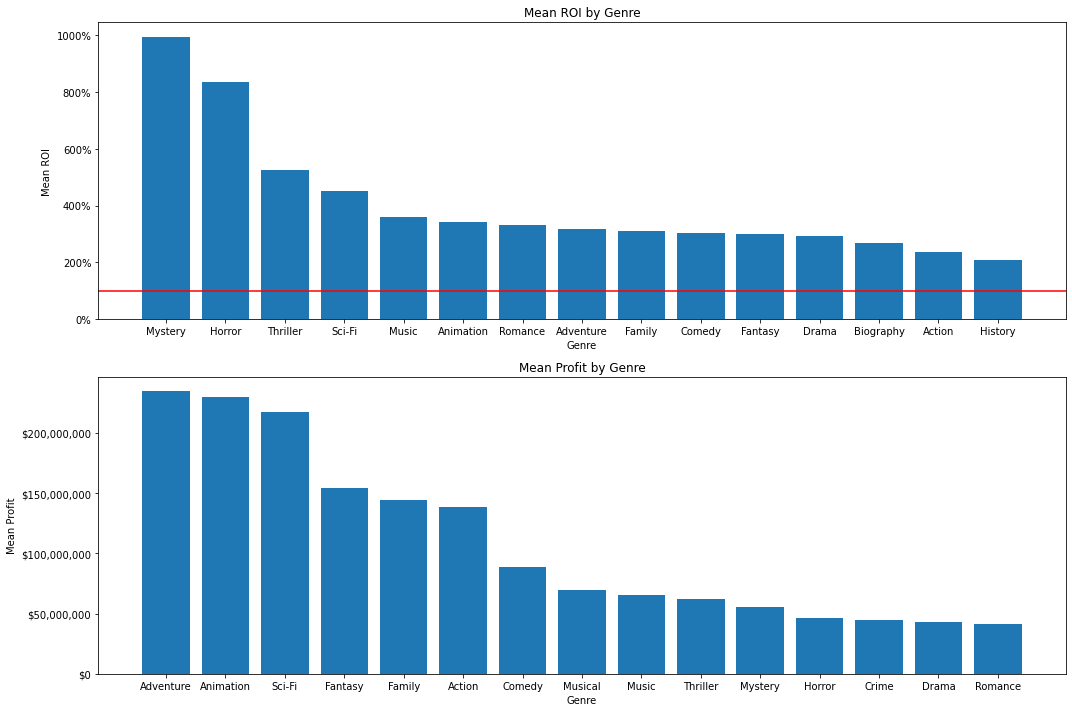

In [20]:
fig, ax = plt.subplots(2,figsize=(15,10))
ax[0].bar(genre_df.genre[:15], genre_df.mean_roi[:15])
ax[0].axhline(100,color='red')
ax[0].set_title('Mean ROI by Genre')
ax[0].set_ylabel('Mean ROI')
ax[0].set_xlabel('Genre')
ax[0].yaxis.set_major_formatter('{x:.0f}%')
ax[1].bar(genre_df.sort_values('mean_profit', ascending=False).genre[:15], genre_df.sort_values('mean_profit', ascending=False).mean_profit[:15])
ax[1].set_title('Mean Profit by Genre')
ax[1].set_ylabel('Mean Profit')
ax[1].set_xlabel('Genre')
ax[1].yaxis.set_major_formatter('${x:,.0f}')
plt.tight_layout()
fig.savefig('./figures/mean_roi_and_profit_by_genre.png')


genre_df.sort_values('mean_roi', ascending=False)[['genre','mean_roi']][:15].to_csv('csv/genre_df_genre_mean_roi.csv')

Here we can see that the top genres for <strong>Mean ROI</strong> are: <strong>Mystery and Horror</strong>. This is not very surprising as horror and mystery movies often have low budgets with much larger profits.

And when it comes to <strong>Gross Profit</strong>, we see the top genres are <strong>Adventure, Animation, and Sci-Fi</strong>.

<br>


<h2>Genre Pairs</h2>

Let's take a look at the top genres pairs. What two genres paired together on a movie are the most profitable?

<h3>Genre Pairs Mean ROI and Mean Profit</h3>

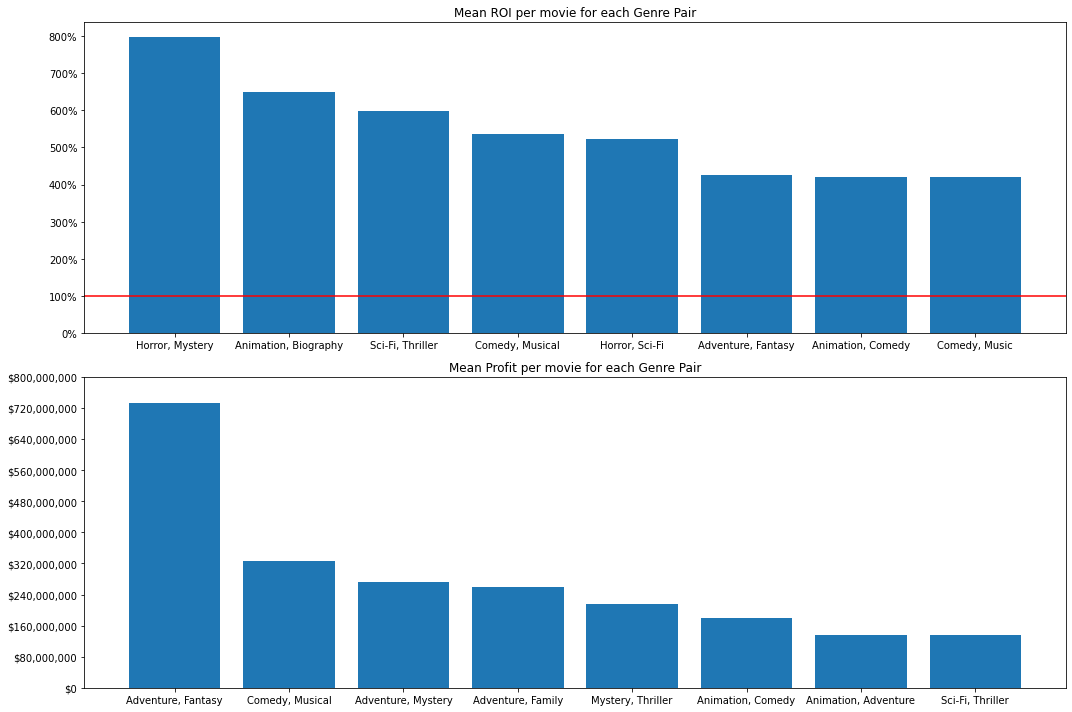

In [21]:
double_genre = imdb_budgets.groupby(['genre_1','genre_2'])
roi_by_double_genre = double_genre['roi'].median().sort_values(ascending=False)[:8]

fig, ax = plt.subplots(2, figsize = (15,10))
ax[0].bar([x[0] +', ' + x[1] for x in roi_by_double_genre.index], roi_by_double_genre)
ax[0].set_title('Mean ROI per movie for each Genre Pair')
ax[0].axhline(100, color='red')
ax[0].yaxis.set_major_formatter('{x:,.0f}%')

profit_by_double_genre = double_genre['profit'].median().sort_values(ascending=False)[:8]
ax[1].bar([x[0] +', ' + x[1] for x in profit_by_double_genre.index], profit_by_double_genre)
ax[1].set_title('Mean Profit per movie for each Genre Pair')
ax[1].yaxis.set_ticks(np.linspace(0,800000000,11))
ax[1].yaxis.set_major_formatter('${x:,.0f}')

plt.tight_layout()
fig.savefig('./figures/genre_pairs_roi_and_profit.png')

As we saw before, Horror and Mystery are the most profitable genres, and together they are also the top genre pair.

It seems that films that have the genres Adventure and Fantasy create the most gross profit. One film genre pair to rule them all.

<h1>Question 2 - Studio Profitability</h1>

<h3>What makes a studio profitable? Can a studio make a larger profit or larger ROI while focusing on a small set of genres?</h3>

<p>Let's explore these questions in this next section. First, let's slice the rows of titles from studios that have made more than 5 features from 2010-2021.</p>

In [22]:
#slice a copy of the dataframe for titles from studios that have made more than 5 features
studios_with_more_than_5_features = pd.DataFrame(imdb_budgets.groupby('main_creator').filter(lambda x: len(x) > 5))
studios_with_more_than_5_features_groupby = studios_with_more_than_5_features.groupby('main_creator')

#create lists of all the genres in each genre column
genre_lists = []
for i in range(3):
    genre_lists.append(studios_with_more_than_5_features_groupby[f'genre_{i+1}'].unique().values)
    
#create sets from the lists so we only get unique values
studio_genre_sets = []
for i, list_ in enumerate(zip(genre_lists[0],genre_lists[1],genre_lists[2])):
    genre_set = set()
    for sublist in list_:
        for item in sublist:
            if item != None:
                genre_set.add(item)
    studio_genre_sets.append(list(genre_set))
    
#save the aggregate data to a DataFrame    
studios_genre_df = pd.DataFrame()
studios_genre_df['studio'] = studios_with_more_than_5_features_groupby['genre_1'].unique().index
studios_genre_df['genres'] = studio_genre_sets
studios_genre_df['genre_count'] = studios_genre_df['genres'].map(lambda x: len(x))
studios_genre_df['mean_roi'] = studios_with_more_than_5_features_groupby.roi.mean().values
studios_genre_df['mean_profit'] = studios_with_more_than_5_features_groupby.profit.mean().values
studios_genre_df['mean_budget'] = studios_with_more_than_5_features_groupby.budget.mean().values
studios_genre_df['total_budget'] = studios_with_more_than_5_features_groupby.budget.sum().values
studios_genre_df['total_profit'] = studios_with_more_than_5_features_groupby.profit.sum().values
studios_genre_df['num_movies'] = studios_with_more_than_5_features_groupby.profit.count().values
studios_genre_df['genres_per_movies'] = studios_genre_df['genre_count'] / studios_genre_df['num_movies']


In [23]:
#sort by Mean ROI and display first 5 rows
studios_genre_df.sort_values('mean_roi',ascending=False, inplace=True)
studios_genre_df.reset_index(drop=True, inplace=True)
studios_genre_df.head()

,studio,genres,genre_count,mean_roi,mean_profit,mean_budget,total_budget,total_profit,num_movies,genres_per_movies
0,New Line Cinema,"[Horror, Fantasy, Musical, Music, Mystery, Cri...",13,1862.163347,1.678181e+08,5.173611e+07,1.862500e+09,6.041450e+09,36,0.361111
1,FilmDistrict,"[Horror, Mystery, Crime, Action, Comedy, Thril...",8,1593.304957,4.188916e+07,1.710714e+07,1.197500e+08,2.932241e+08,7,1.142857
2,Exclusive Media Group,"[Horror, Music, History, Biography, Mystery, C...",11,1342.212053,2.258175e+07,1.335556e+07,1.202000e+08,2.032357e+08,9,1.222222
3,Blumhouse Productions,"[Family, Horror, Mystery, Crime, Sci-Fi, Actio...",10,856.566135,4.973896e+07,5.914286e+06,8.280000e+07,6.963454e+08,14,0.714286
4,Screen Gems,"[Adventure, Horror, Fantasy, Music, Musical, M...",12,703.140690,5.144489e+07,2.347071e+07,6.571800e+08,1.440457e+09,28,0.428571


In [24]:
#example of the list of genres in the first row of data
print(studios_genre_df.loc[0,'studio'], studios_genre_df.loc[0,'genres'])

New Line Cinema ['Horror', 'Fantasy', 'Musical', 'Music', 'Mystery', 'Crime', 'Sci-Fi', 'Action', 'Romance', 'Comedy', 'Thriller', 'Adventure', 'Drama']


<h2>Visualize the Mean ROI per Title by Studio</h2>

Let's plot the Mean ROI per title of each studio against the number of genres that studio produces.

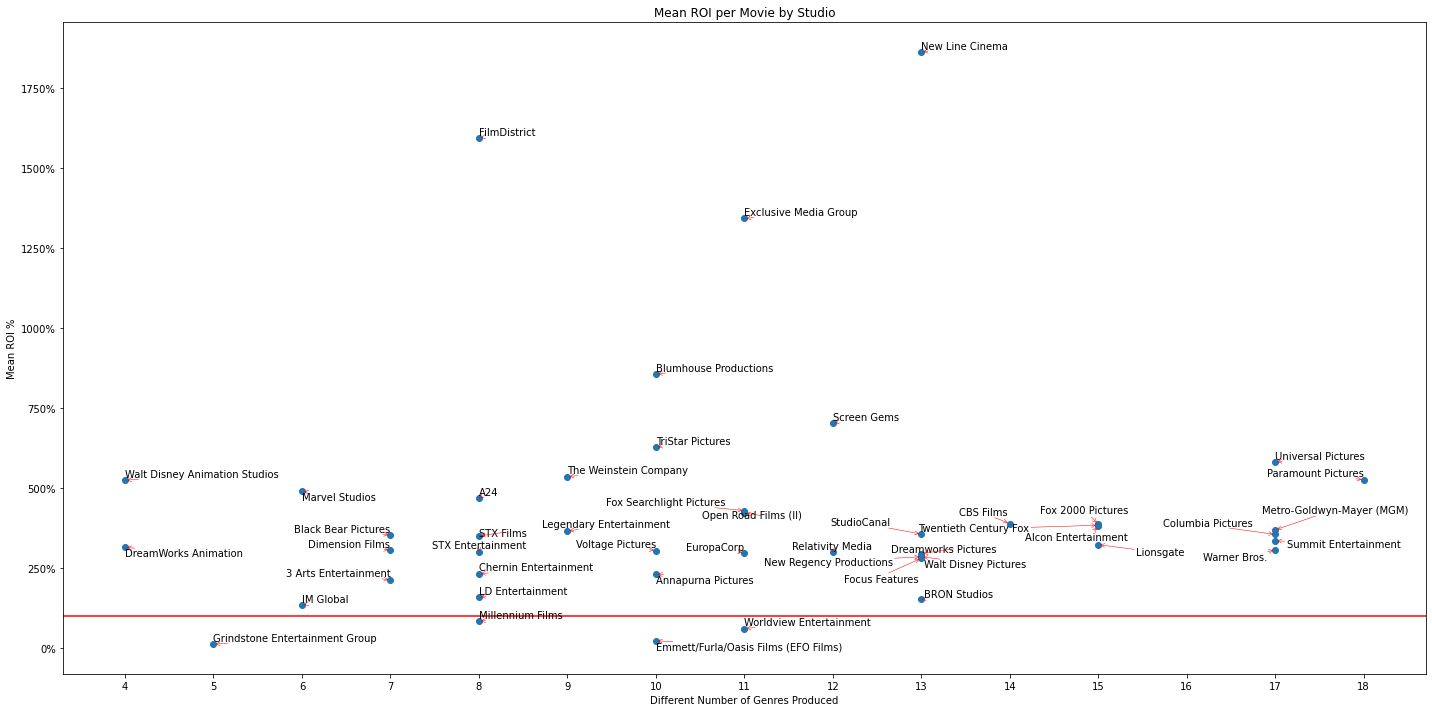

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(studios_genre_df.genre_count, studios_genre_df.mean_roi)
ax.axhline(100, color='red')
texts = []
for i, txt in enumerate(studios_genre_df.studio):
    texts.append(ax.annotate(txt, (studios_genre_df.genre_count[i], studios_genre_df.mean_roi[i]), fontsize=10))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
ax.set_title('Mean ROI per Movie by Studio')
ax.set_ylabel('Mean ROI %')
ax.set_xlabel('Different Number of Genres Produced')
ax.yaxis.set_major_formatter('{x:.0f}%')
ax.xaxis.set_ticks(np.linspace(4,18,15))
plt.tight_layout()
plt.show()
fig.savefig('./figures/mean_roi_byStudio.png')


Studios like New Line Cinema, which produce many profitable horror and mystery films also have a high ROI.

In [26]:
imdb_budgets.query('main_creator == "New Line Cinema"').groupby(['genre_1','genre_2']).roi.mean()

genre_1    genre_2  
Action     Adventure     293.125977
           Comedy        433.945086
           Horror        394.719108
Adventure  Comedy        190.488289
           Fantasy       384.880535
Comedy     Crime         664.626288
           Drama         196.563826
           Romance       260.203134
Crime      Drama         330.557663
Drama      Fantasy       598.889272
           Horror        260.974570
           Romance       245.911889
Horror     Mystery      6341.394172
Name: roi, dtype: float64

<h2>Visualize the Mean Profit per Title by Studio</h2>

What we really want to see is the max mean profit of each studio. Let's plot the Mean Profit per title of each studio against the number of genres that studio produces.

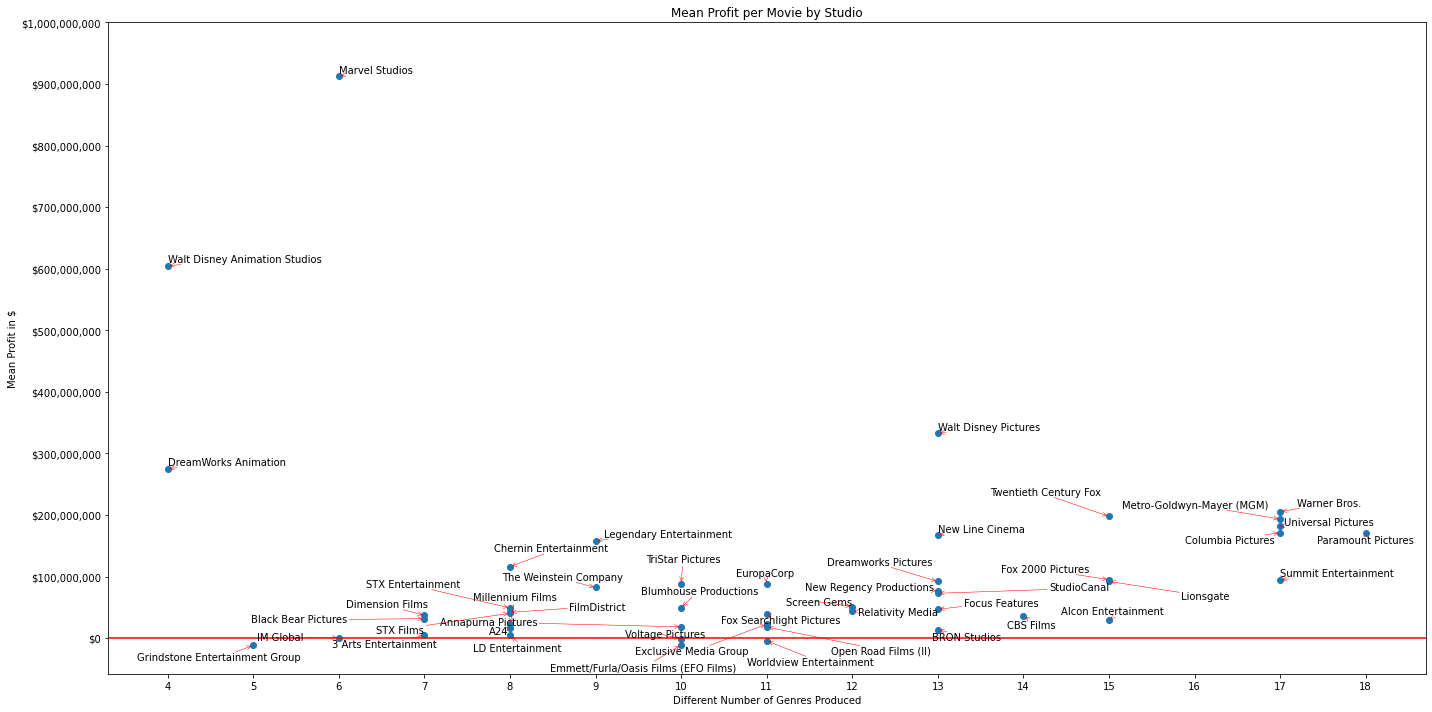

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(studios_genre_df.genre_count, studios_genre_df.mean_profit)
ax.axhline(1, color='red')
texts=[]
for i, txt in enumerate(studios_genre_df.studio):
    texts.append(ax.annotate(txt, (studios_genre_df.genre_count[i], studios_genre_df.mean_profit[i]), fontsize=10))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
ax.set_title('Mean Profit per Movie by Studio')
ax.set_ylabel('Mean Profit in $')
ax.yaxis.set_ticks(np.linspace(0,1000000000,11))
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xlabel('Different Number of Genres Produced')
ax.xaxis.set_ticks(np.linspace(4,18,15))
plt.tight_layout()
plt.show()
fig.savefig('./figures/mean_profit_byStudio.png')


The data is a bit more clustered than in the Mean ROI per studio. There is a slight relationship in studio profitability and number of genres produced. While on the other hand, the studios with the least number of genres had the most profitable titles on average.

In [28]:
imdb_budgets.query('main_creator == "Marvel Studios"').groupby(['genre_1','genre_2','genre_3']).roi.mean()

genre_1  genre_2    genre_3
Action   Adventure  Comedy     423.718876
                    Drama      785.814980
                    Fantasy    330.367383
                    Sci-Fi     546.004035
Name: roi, dtype: float64

<h1>Question 3 - Budget Profitability</h1>

<h3>How does the budget affect profitability?</h3>

We will explore how the size of a budget affects the profit. Does a smaller budget have a relationship with a larger ROI? Will a huge budget create a larger gross profit?

First let's explore the mean budget vs. the mean ROI

In [29]:
mean_budget = imdb_budgets.budget.mean()
mean_roi = imdb_budgets.roi.mean()

In [30]:
print("Mean Budget: ${:,.2f}".format(mean_budget))
print("Mean ROI: {:,.2f}%".format(mean_roi))

Mean Budget: $42,664,345.76
Mean ROI: 355.78%


So the mean budget is around $44 million and the mean Return is over 3 times the original investment.

Let's look a scatter chart of all films' budgets vs their roi and also their profit.

<h2>All Films Budgets vs ROI and Profit</h2>

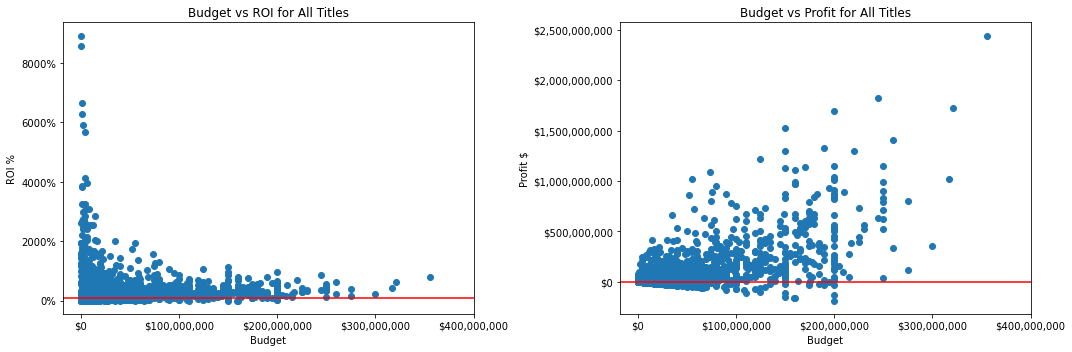

In [31]:
#we will filter out a few outliers that have extraordinary roi's in order to see more of the data closely
filtered_budgets = imdb_budgets.query('roi < 10000')

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(filtered_budgets.budget.values, filtered_budgets.roi.values)
ax[0].set_title('Budget vs ROI for All Titles')
ax[0].yaxis.set_major_formatter('{x:.0f}%')
ax[0].xaxis.set_major_formatter('${x:,.0f}')
ax[0].xaxis.set_ticks(np.linspace(0,4e8,5))
ax[0].set(xlabel='Budget', ylabel='ROI %')
ax[0].axhline(100,color='red')

ax[1].scatter(filtered_budgets.budget.values, filtered_budgets.profit.values)
ax[1].set_title('Budget vs Profit for All Titles')
ax[1].yaxis.set_major_formatter('${x:,.0f}')
ax[1].xaxis.set_major_formatter('${x:,.0f}')
ax[1].set(xlabel='Budget', ylabel='Profit $')
ax[1].xaxis.set_ticks(np.linspace(0,4e8,5))
ax[1].axhline(0,color='red')
plt.tight_layout()
fig.savefig('./figures/budget_vs_roi_and_profit.png', dpi=300)

We can see in the left graph that a very low budget can sometimes lead to very high ROI. In general, the less money spent, the higher the ROI.

Although in the right graph, we see that the more money spent the higher the total profit. This may seem to contradict the previous graph, but actually if a studio is looking for the greatest profit, we can see there is a clear relationship between high profits and high budgets.

Let's take a look a graph of the mean roi vs budget for each genre.

<h2>Mean Budgets vs Mean ROI and Mean Profit for each Genre</h2>

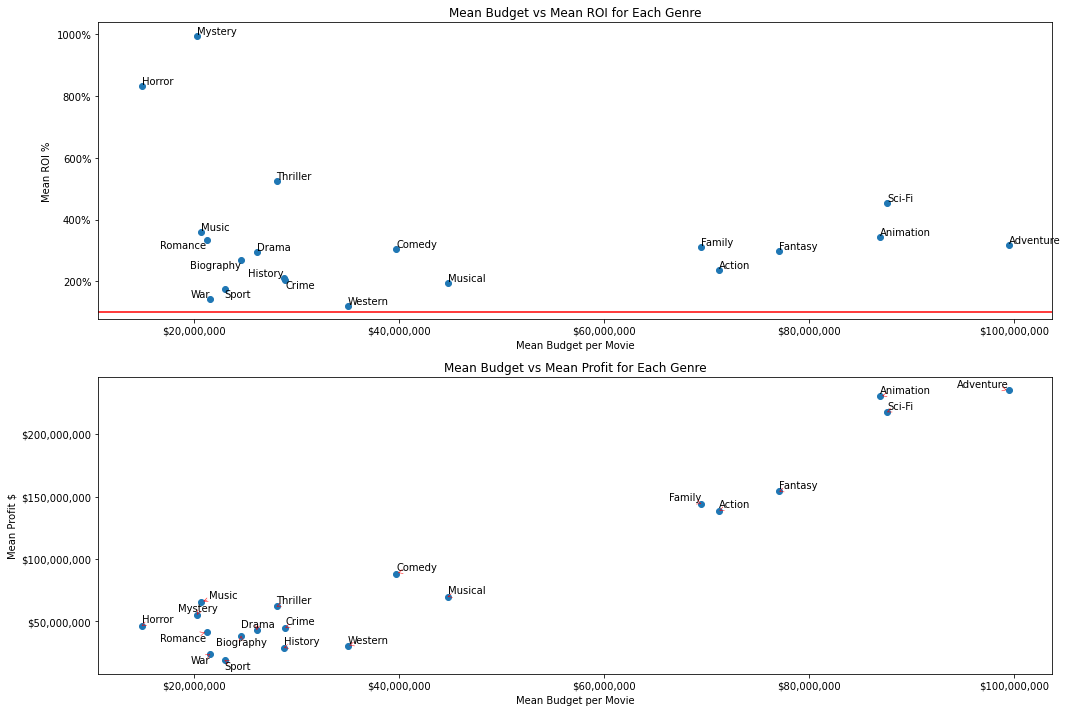

In [32]:
#we saved the mean budgets in our genre_df from before so we will use that dataframe again here
budget_by_genre = genre_df

fig, ax = plt.subplots(2,figsize=(15,10))
ax[0].set_title('Mean Budget vs Mean ROI for Each Genre')
ax[0].scatter(budget_by_genre.mean_budget, budget_by_genre.mean_roi)
ax[0].set_ylabel('Mean ROI %')
ax[0].xaxis.set_major_formatter('${x:,.0f}')
ax[0].set_xlabel('Mean Budget per Movie')
ax[0].yaxis.set_major_formatter('{x:.0f}%')
ax[0].axhline(100, color='red')
texts1 = []
for i, txt in enumerate(budget_by_genre.genre):
    texts1.append(ax[0].annotate(txt, (budget_by_genre.mean_budget[i], budget_by_genre.mean_roi[i])))
adjust_text(texts1, only_move={'points':'y', 'texts':'y'})    
ax[1].set_title('Mean Budget vs Mean Profit for Each Genre')
ax[1].scatter(budget_by_genre.mean_budget, budget_by_genre.mean_profit)
ax[1].set_ylabel('Mean Profit $')
ax[1].yaxis.set_major_formatter('${x:,.0f}')
ax[1].set_xlabel('Mean Budget per Movie')
ax[1].xaxis.set_major_formatter('${x:,.0f}')
texts2 = []
for i, txt in enumerate(budget_by_genre.genre):
    texts2.append(ax[1].annotate(txt, (budget_by_genre.mean_budget[i], budget_by_genre.mean_profit[i])))
adjust_text(texts2, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    
plt.tight_layout()
fig.savefig('./figures/budget_vs_roi_and_profit_by_genre.png')

Again, this is similiar data to what we explored in our Genre Profitability graphs.

Here we can see how the <strong>low budgets</strong> of Horror and Mystery lead to <strong>high ROI's</strong>.

And in the bottom graph, we see the top mean profit genres of Adventure, Animation, and Sci-fi again leading in mean profit. What we haven't seen before is that these <strong>top mean profit genres</strong> also have the <strong>highest mean budgets</strong>.

<h2>Budgets vs ROI and Profit for Each Studio</h2>

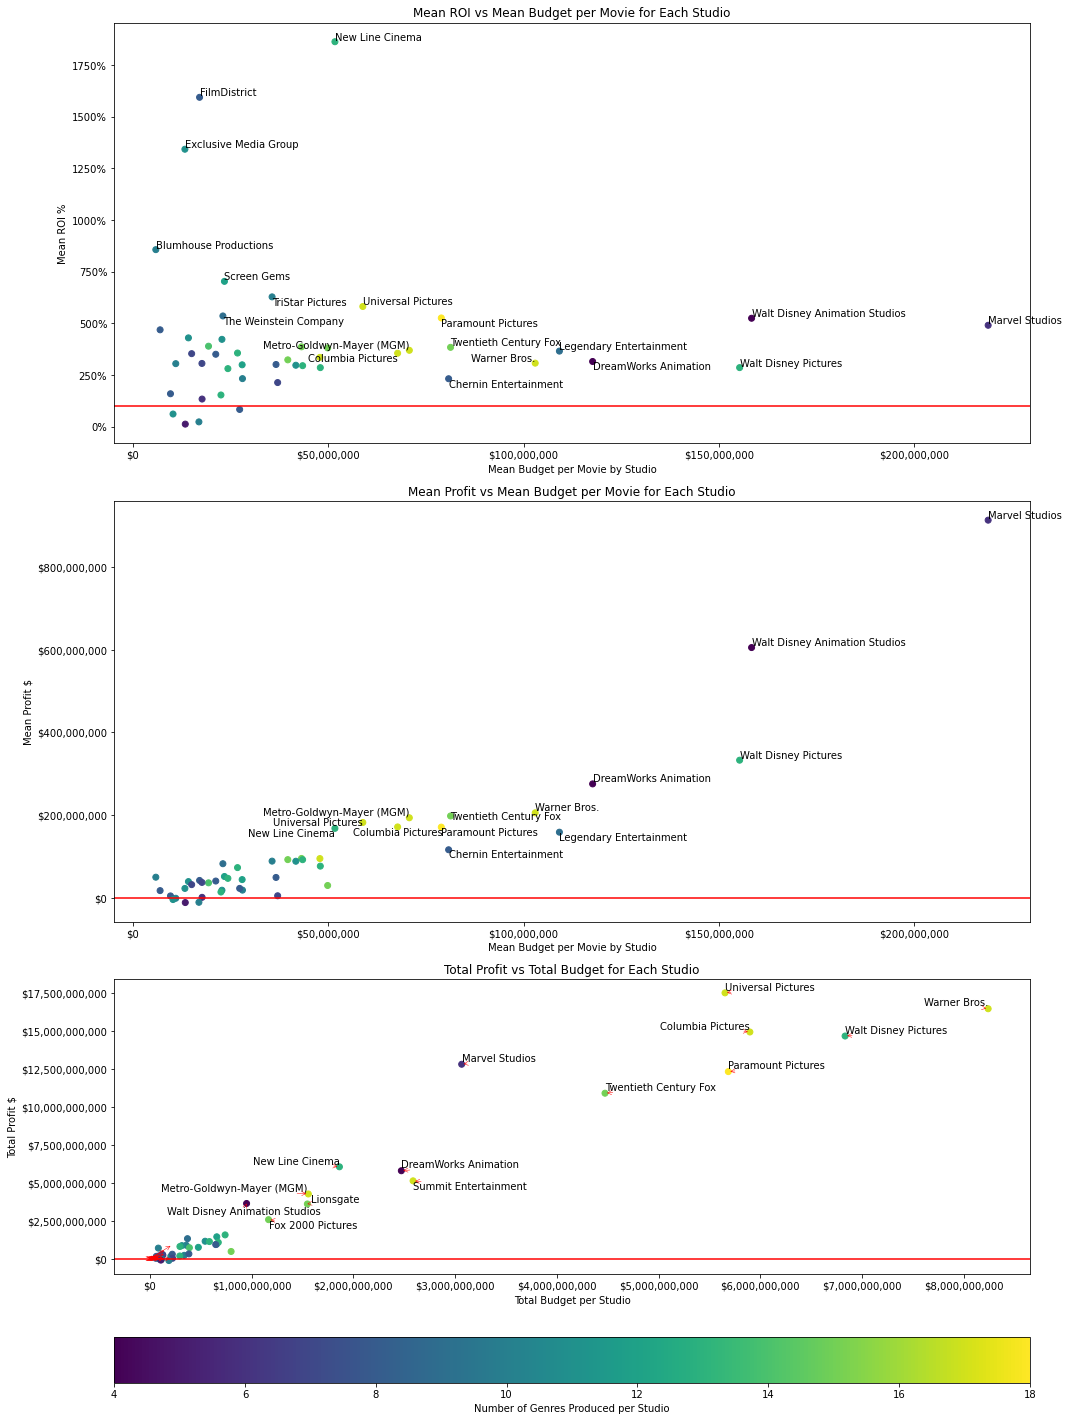

In [33]:
#Labels for some of the data is not displayed for better clarity.

fig, ax = plt.subplots(3, figsize=(15,20))
ax0 = ax[0].scatter(studios_genre_df.mean_budget, studios_genre_df.mean_roi, c=studios_genre_df.genre_count)
ax[0].set_title('Mean ROI vs Mean Budget per Movie for Each Studio')
ax[0].set_ylabel('Mean ROI %')
ax[0].yaxis.set_major_formatter('{x:.0f}%')
ax[0].set_xlabel('Mean Budget per Movie by Studio')
ax[0].xaxis.set_major_formatter('${x:,.0f}')
ax[0].axhline(100, color='red')
texts1 = []
for i, txt in enumerate(studios_genre_df.studio):
    if studios_genre_df.mean_budget[i] > 5e7 or studios_genre_df.mean_roi[i] > 500:
        texts1.append(ax[0].annotate(txt, (studios_genre_df.mean_budget[i], studios_genre_df.mean_roi[i])))
adjust_text(texts1, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

ax1 = ax[1].scatter(studios_genre_df.mean_budget, studios_genre_df.mean_profit, c=studios_genre_df.genre_count)
ax[1].set_title('Mean Profit vs Mean Budget per Movie for Each Studio')
ax[1].set_ylabel('Mean Profit $')
ax[1].yaxis.set_major_formatter('${x:,.0f}')
ax[1].set_xlabel('Mean Budget per Movie by Studio')
ax[1].xaxis.set_major_formatter('${x:,.0f}')
ax[1].axhline(0, color='red')
texts2 = []
for i, txt in enumerate(studios_genre_df.studio):
    if studios_genre_df.mean_budget[i] > 5e7:
         texts2.append(ax[1].annotate(txt, (studios_genre_df.mean_budget[i], studios_genre_df.mean_profit[i])))
adjust_text(texts2, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))


ax2 = ax[2].scatter(studios_genre_df.total_budget, studios_genre_df.total_profit, c=studios_genre_df.genre_count)
ax[2].set_title('Total Profit vs Total Budget for Each Studio')
ax[2].set_ylabel('Total Profit $')
ax[2].yaxis.set_major_formatter('${x:,.0f}')
ax[2].set_xlabel('Total Budget per Studio')
ax[2].xaxis.set_major_formatter('${x:,.0f}')
ax[2].axhline(0, color='red')
texts3 = []
for i, txt in enumerate(studios_genre_df.studio):
    if studios_genre_df.total_budget[i] > 8e8:
         texts3.append(ax[2].annotate(txt, (studios_genre_df.total_budget[i], studios_genre_df.total_profit[i])))
adjust_text(texts3, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

cbar = fig.colorbar(ax2, ax=ax[2], orientation='horizontal')
cbar.ax.set_xlabel('Number of Genres Produced per Studio')
fig.tight_layout()
fig.savefig('./figures/budget_vs_roi_and_profit_by_Studio.png', dpi=300)

In these graphs, we are revisting some of the same intuitions we explored in the Studio Profitability graphs. 

We see in the top graph for ROI vs Budget, a studio like New Line Cinema has the highest ROI and a mean budget on the lower end in this range of studios. New Line Cinema produces hits movies in genres that have high ROI.

In the middle graph for Mean Profit per Movie vs Budget, we see that Marvel Studios leads in both profit and budget. Marvel focuses on superheros, action, sci-fi, adventure films that produce high profits.

In the bottom graph, we are looking at the Total Profit vs Total Budget per Studio. There seems to be a clear relationship, as in all the previous graphs in this section dealing with profit, between a high budget and a high profit. The studios who spent the most money also made the most gross profit.

The most profitable studio is Universal Studios. They also produce a lot of different genres. They have one of the highest total budgets. Although per movie, they have a mean profit similiar to New Line Cinema, which has a much higher ROI. This would mean that although Universal is making more gross profit, New Line is making more bang for their buck.

Pay special attention to the color of each dot. Each dot is more purple when a studio explored producing less genres, and turns yellow as the variance of genres increases. We can see that the studios with the highest amount of money spent also produced the most genres. But on the other hand, studios like Marvel and Disney produce less genres each, but still have the highest mean profits per movie.


<h1>Conclusions</h1>

<h3>Our analysis leads to the following main conclusions:</h3>

<h3>Genre Profitability</h3>
<ul>
<li>The most profitable genres are <strong>Horror, Mystery, Adventure, Animation, and Sci-Fi.</strong>. Horror and Mystery are the most profitable in terms of ROI percentage, and Adventure and Fantasy create the largest gross profit</li>
</ul>
<h3>Studio Profitability</h3>
<ul>
    <li>The <strong>most profitable movies</strong> are from studios focusing on producing <strong>less genres</strong>. While most studios were profitable overall, the studios with the highest mean profit per movie, decided to focus on a smaller set of profitable genres, rather than diversify the number of genres produced. There are two directions a studio like Microsoft should choose to take. To focus on producing movies in genres that have high returns or movies that have high profits.</li>
</ul>
<h3>Budget Profitability</h3>
<ul>
    <li><strong>Spend less, and make more, or spend more and make A LOT more.</strong> While genres like Horror and Mystery may cost less and have a higher return, the studios that spent more money per movie, made the most gross profit. Also, movie genres that may require a higher budget to produce (Adventure, Animation, Sci-Fi) also created the most gross profit.</li>
</ul>

<strong>If Microsoft were to create a movie studio, they should consider the investment they choose to make in production. With a high budget, they can choose to produce films that have much higher profits. If they choose to spend less, they should focus on the movies with the highst returns.</strong>

Furthermore, I have some intuitions about the data that would require further research:
<ul>
    <li>With the disruption caused by the global pandemic from 2020 and ongoing, the rise and dominance of streaming sites, and many other factors, there are many movies being released currently that never reach theaters. Our analysis cannot determine the profitability of films released by streaming sites like Netflix because their profitability cannot be determined from budget and box office data available on IMDB.</li>
    <li>The total box office data does not include revenue created by royalties from syndication, physical sales, and streaming licenses. Like our point above, we cannot determine the lifetime profitability based on box office data alone.</li>
 </ul>